In [1]:
%load_ext autoreload
%autoreload 2


# numpy provides import array and linear algebra utilities
import numpy as np
# casadi is a library for symbolic computation
import casadi as ca
# the transformations module provides functions for creating transformations
import utils.transformations as ta
from example_robot_data import load
from pinocchio.visualize import MeshcatVisualizer
import time
import meshcat
import matplotlib.pyplot as plt


# Robotics Course : Control Exercise

## Part 2 : Implement a task-space controller

In this section the goal is to implement a controller that directly controls the robot in Cartesian space.
Some code is provided with a simulation environment, and your role is to compute the control input given the task error, task Jacobian, and feedforward terms.

In part 1, you (hopefully) designed a controller that allows the robot to track joint position, velocity and acceleration references.
Therefore, this part assumes that the velocity of each joint can be directly controlled (with a controller similar to the one designed in part 1).
However, be careful!
If your task space controller is too aggressive, your feedback controller may become unstable...


### Load a robot and create a visualization environment

In [2]:
robot = load("panda")
viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(loadModel=True)

# Add floor
material_black = meshcat.geometry.MeshPhongMaterial()
material_black.color = int(100) * 256**2 + int(100) * 256 + int(100)
viz.viewer['floor'].set_object(meshcat.geometry.Box([1.25, 1, 0.01]), material_black)
viz.viewer['floor'].set_transform(ta.SE3_from_xyz_rpy([0.375, 0, -0.01], [0, 0, 0]))

# Set initial joint angles
q0 = np.array([-0.37, -0.88, -0.24, -2.35, -0.18,  1.47, 0.24])
viz.display(np.append(q0, [0,0]))
# viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


### Model the system

#### Forward kinematics of the robot
Load a casadi function for the forward kinematics of the Franka Panda robot (generated with Pinocchio) 

$$T_{\text{w,ee}} (q) = \texttt{fk}(q) $$

In [3]:
# load casadi function for the forward kinematics of the end effector
# this function was generate using Pinocchio as shown in exercise 1
T_world_ee_fn = ca.Function.load('panda_T_world_ee.casadi')

#### Goal trajectory to follow

Define a goal trajectory $ T_{\text{w,goal}}(t) $ for the robot to follow: 

In [4]:
t_sym = ca.MX.sym("t_sym")

# define the target pose
T_world_goal = ta.SE3_from_xyz_rpy(
    xyz=[0.5-0.3*ca.cos(t_sym), 0, 0.5], rpy=[np.pi,0,0])

# convert to a casadi function to evaluate numerically
T_world_goal_fn = ca.Function("T_world_goal_fn", [t_sym], [
                              T_world_goal], ["t"], ["T_world_goal"])

#### Pose error between the end-effector and the goal

Compute the error between the end-effector and the goal:

$$
e(q, t) = \begin{bmatrix} \texttt{axis\_angle}( R_{\text{ee,goal}} (q, t) \\_\text{ee} p ^\text{ee, goal} ) \end{bmatrix} 
$$

where

$$
\begin{align*}
T_{\text{ee,goal}} (q, t) &= (T_{\text{w,ee}}(q))^{-1} T_{\text{w,goal}} (t) \\
&= \begin{bmatrix}R_{\text{ee,goal}}(q, t) & _\text{ee} p ^\text{ee, goal} \\ 0_{3 \times 3} & 1 \end{bmatrix}
\end{align*}
$$

In [5]:
q_sym = ca.MX.sym("q_sym", 7)

# compute the transformation between ee and goal
T_world_ee = T_world_ee_fn(q_sym)
T_ee_goal = ta.inverse_SE3(T_world_ee) @ T_world_goal

# extract the position error
pos_error = T_ee_goal[:3, 3]
# extract the orientation error
R_ee_goal = T_ee_goal[:3, :3]
ori_error = ta.axis_angle_from_rotation_matrix(R_ee_goal)
# stack the position and orientation error
e_sym = ca.vertcat(ori_error, pos_error)

# compute the jacobian of the error
J_e_sym = ca.jacobian(e_sym, q_sym)
# compute the feed forward term
feed_forward = ca.jacobian(e_sym, t_sym)

# convert to a casadi function to evaluate numerically
e_func = ca.Function("e", [q_sym, t_sym], [e_sym], ["q", "t"], ["e"])
J_e_func = ca.Function("J_e", [q_sym, t_sym], [J_e_sym], ["q", "t"], ["e"])
feed_forward_func = ca.Function("feed_forward", [q_sym, t_sym], [feed_forward], ["q", "t"], ["feed_forward"])

# Add frames to visualization
viz.viewer['T_w_ee'].set_object(meshcat.geometry.triad(0.1))
viz.viewer['T_w_ee'].set_transform(T_world_ee_fn(q0).full())

viz.viewer['target'].set_object(meshcat.geometry.triad(0.1))
viz.viewer['target'].set_transform(T_world_goal_fn(0).full())

### The simulation loop


In [6]:
def simulate(controller, q0):
    """
    Simulates the robot using the given controller and initial joint positions.

    Parameters:
    controller (function): The robot controller function.
    q0 (numpy.ndarray): The initial joint positions of the robot.
    """

    # set parameters for the simulation
    control_freq = 100 #hz
    render_freq = 32 #hz
    sim_time = 10 #sec

    q = q0

    # create a torque robot simulation
    from utils.robot_simulator import VelocityRobotSim
    robot_sim = VelocityRobotSim(q0 = q0, n_joints = 7, alpha_internal = 30)

    errors = []
    t_vec = np.arange(0, sim_time, 1/control_freq)
    for t in t_vec:
        q = robot_sim.get_joint_pos()
        # compute the joint velocities using the robot controller function
        dq = controller(q, t)

        robot_sim.step(dq, 1/control_freq)

        # store the error
        error = e_func(q, t).full().ravel()
        errors.append(error)

        viz.viewer['target'].set_transform(T_world_goal_fn(t).full())
        viz.viewer['T_w_ee'].set_transform(T_world_ee_fn(q).full())

        # update the visualization at the correct rate
        if t % (1/render_freq) < 1/control_freq:
            # add two zeroes to end of q for gripper joints
            q_robot = np.append(q, [0, 0])
            viz.display(q_robot)
            time.sleep(1 /(render_freq))

    # Plot the errors
    error_array = np.array(errors)

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # Plot position errors
    axs[0].plot(t_vec, error_array[:, :3])
    axs[0].set_ylabel('Orientation error [rad]')
    axs[0].set_title('Orientation errors over time')
    axs[0].grid()

    # Plot orientation errors
    axs[1].plot(t_vec, error_array[:, 3:])
    axs[1].set_xlabel('Time step')
    axs[1].set_ylabel('Position error [m]')
    axs[1].set_title('Position errors over time')
    axs[1].grid()

    plt.tight_layout()
    plt.show()

The task space controller will implement a proportional controller with time constant $K^{-1}$ directly in the task space.
$$
\begin{align*}
\frac{\text{d}}{\text{d} t} e(q,t)  &= - K \, e(q,t) \\
\frac{\partial e(q, t)}{\partial q} \dot{q} + \frac{\partial e (q, t)}{\partial t} &= - K \, e(q, t) \\
\underbrace{\frac{\partial e (q, t)}{\partial q}}_{\text{jacobian}}\dot{q}  &= - K \, \underbrace{e(q, t)}_{\text{error}} - \underbrace{\frac{\partial e (q, t)}{\partial t}}_{\text{feedforward}}
\end{align*}
$$

<!-- $$
\begin{align*}
 \dot{q}  &= - \frac{\partial e (q, t)}{\partial q}^{\dagger}\big( k \, e(q, t) + \frac{\partial e (q, t)}{\partial t}\big)
 \end{align*}
$$ -->

### Questions
- 2.1 Implement the task-space controller using a
    - 2.1.1 pseudoinverse approach.
    - 2.1.2 damped least-squares approach.
    - 2.1.3 weighted least-squares approach.
- 2.2 Explain why the approach fails for the pseudoinverse, and how the damping terms alleviates the problem. What behaviour do you observe now? Why does this work? Try different values of the regularisation $\mu$. What happens to the tracking performance when you increase the size of $\mu$? Can you explain why?
- 2.3 When using the damped least squares approach, which task is being prioritized? The position or the orientation? Why?
- 2.4 Can you use the weighted least squares to prioritize the position error?
- 2.5 Investigate the role of the feedforward term in the control law:
    - 2.5.1 What happens if there is only feedback (no feedforward)?
    - 2.5.2 What happens if there is only feedforward (no feedback)?

- 2.6 (Optional) Implement the weighted damped least-squares controller as an optimization problem using CasADi Opti:
    - Include inequality constraints for the robot joint positon and/or velocity limits.
- 2.7 (Optional) Implement a hierarchical controller that prioritises the position tracking above the orientation tracking
    - e.g. using a QP controller or null-space projection

### Task 2.1.1 : Implement the task-space controller using the pseudoinverse approach


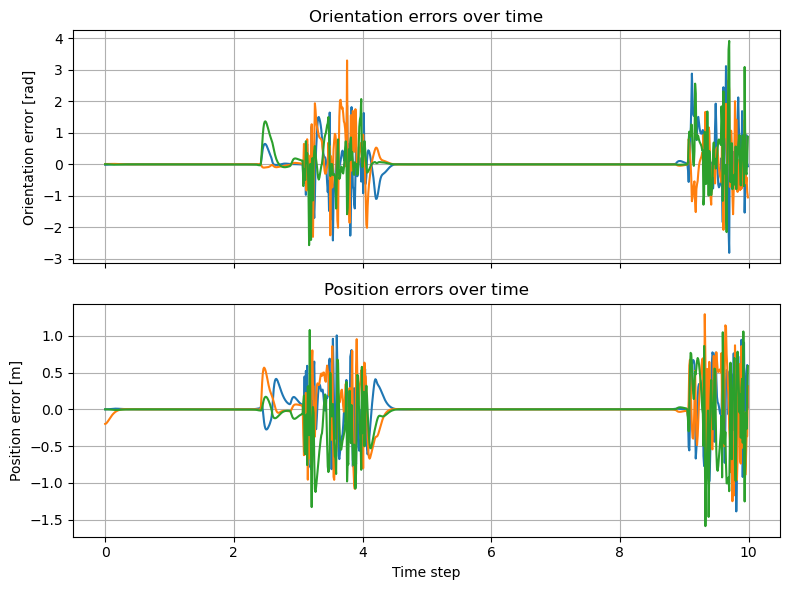

In [12]:
def controller_pinv(q,t):
    """
    Computes the control input using the pseudoinverse of the Jacobian.

    Parameters:
    q (numpy.ndarray): The current joint positions of the robot.
    t (float): The current time.

    Returns:
    numpy.ndarray: The control input for the robot.
    """

    # get the error as a numpy array from the casadi function
    error = e_func(q,t).full()
    # get the jacobian as a numpy array from the casadi function
    jacobian = J_e_func(q, t).full()
    # get the feed forward term as a numpy array from the casadi function
    feed_forward = feed_forward_func(q, t).full()

    K = 10  # [seconds^{-1}]

    ##################################
    # TODO: implement your controller here
    dq = np.array([0,0,0,0,0,0,0])  # [rad/s]
    
    pseudoInv = np.linalg.pinv(jacobian)
    dq = pseudoInv @ (-K * error - feed_forward)

    ##################################
    

    return dq.ravel()


simulate(controller_pinv, q0)

### Task 2.1.2 : Implement the task-space controller using a damped least-squares approach

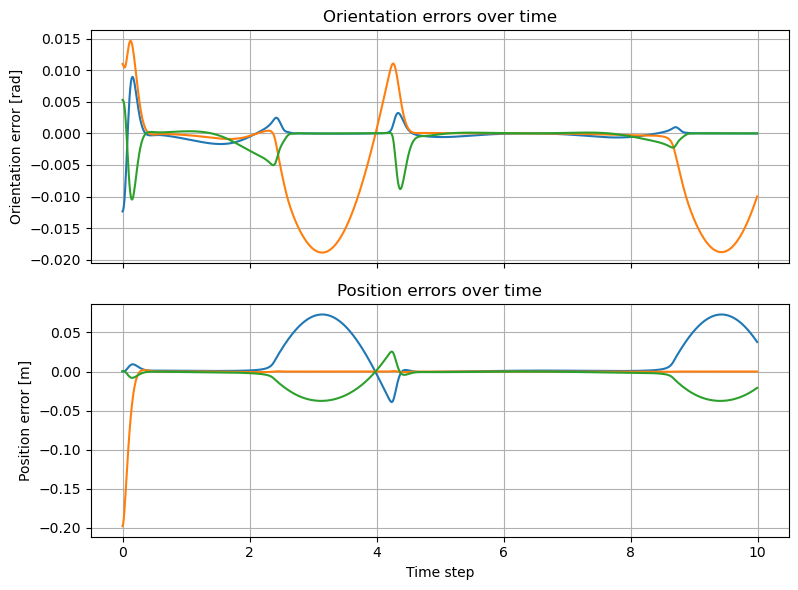

In [14]:
def controller_dls(q, t):
    """
    Computes the control input using the damped least-squares approach

    Parameters:
    q (numpy.ndarray): The current joint positions of the robot.
    t (float): The current time.

    Returns:
    numpy.ndarray: The control input for the robot.
    """

    # get the error as a numpy array from the casadi function
    error = e_func(q, t).full()
    # get the jacobian as a numpy array from the casadi function
    jacobian = J_e_func(q, t).full()
    # get the feed forward term as a numpy array from the casadi function
    feed_forward = feed_forward_func(q, t).full()

    K = 10  # [seconds^{-1}]
    mu = 1e-3
    
    ##################################
    # TODO: implement your controller here
    dq = np.array([0,0,0,0,0,0,0])  # [rad/s]
    dq = np.linalg.inv(jacobian.T @ jacobian + mu* np.eye(7)) @ jacobian.T @ (-K * error - feed_forward)
    
    ##################################


    return dq.ravel()


simulate(controller_dls, q0)

### Task 2.1.3 : Implement the task-space controller using a weighted least-squares approach

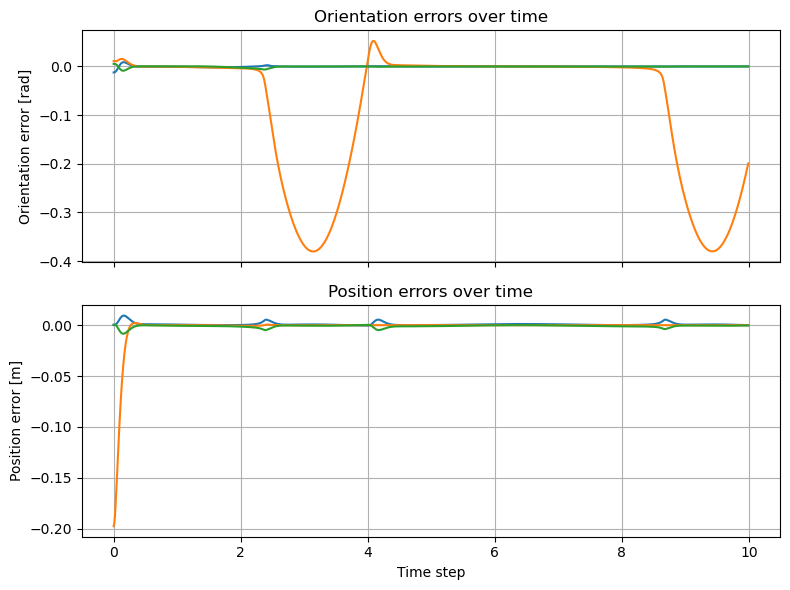

In [15]:
def controller_wls(q, t):
    """
    Computes the control input using the weighted least-squares of the Jacobian.

    Parameters:
    q (numpy.ndarray): The current joint positions of the robot.
    t (float): The current time.

    Returns:
    numpy.ndarray: The control input for the robot.
    """

    # get the error as a numpy array from the casadi function
    error = e_func(q, t).full()
    # get the jacobian as a numpy array from the casadi function
    jacobian = J_e_func(q, t).full()
    # get the feed forward term as a numpy array from the casadi function
    feed_forward = feed_forward_func(q, t).full()

    K = 10
    mu = 1e-2
    # Larger weights for position than orientation
    W = np.diag([1, 1, 1, 1e3, 1e3, 1e3])

    ##################################
    # TODO: implement your controller here
    dq = np.array([0,0,0,0,0,0,0])  # [rad/s]
    dq = np.linalg.inv(jacobian.T @ W @ jacobian + mu* np.eye(7)) @ jacobian.T @ W @ (-K * error - feed_forward)
    
    ##################################



    return dq.ravel()

simulate(controller_wls, q0)